In [12]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import trange

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer_sizes = [20, 20, 20, 20]
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, self.hidden_layer_sizes[0]))
        for i in range(len(self.hidden_layer_sizes) - 1):
            self.layers.append(nn.Linear(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i + 1]))
        self.layers.append(nn.Linear(self.hidden_layer_sizes[-1], 1))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = torch.tanh(self.layers[i](x))
        return self.layers[-1](x)

# Define the PDE loss function
def pde_residual(model, x, t):
    u = model(torch.cat([x, t], dim=1))
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    return u_t + u * u_x - (0.01 / np.pi) * u_xx

# Define the loss function
def loss_function(model, x_collocation, t_collocation, x_initial, u_initial, x_boundary, t_boundary):
    # PDE residual loss at collocation points
    pde_loss = torch.mean(pde_residual(model, x_collocation, t_collocation) ** 2)
    
    # Initial condition loss
    u_pred_initial = model(torch.cat([x_initial, torch.zeros_like(x_initial)], dim=1))
    initial_loss = torch.mean((u_pred_initial - u_initial) ** 2)
    
    # Boundary condition loss
    u_boundary_left = model(torch.cat([torch.full_like(t_boundary, -1), t_boundary], dim=1))
    u_boundary_right = model(torch.cat([torch.full_like(t_boundary, 1), t_boundary], dim=1))
    boundary_loss = torch.mean(u_boundary_left ** 2) + torch.mean(u_boundary_right ** 2)
    
    return pde_loss + initial_loss + boundary_loss

# Generate collocation, initial, and boundary points
N_collocation = 10000
N_initial = 100
N_boundary = 200

# Collocation points
x_collocation = torch.tensor(np.random.uniform(-1, 1, (N_collocation, 1)), requires_grad=True, dtype=torch.float32).to(device)
t_collocation = torch.tensor(np.random.uniform(0, 1, (N_collocation, 1)), requires_grad=True, dtype=torch.float32).to(device)

# Initial condition points
x_initial = torch.tensor(np.random.uniform(-1, 1, (N_initial, 1)), dtype=torch.float32).to(device)
u_initial = -torch.sin(np.pi * x_initial).to(device)

# Boundary condition points
t_boundary = torch.tensor(np.random.uniform(0, 1, (N_boundary, 1)), dtype=torch.float32).to(device)

# Initialize the model and optimizer
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in trange(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_collocation, t_collocation, x_initial, u_initial, x_initial, t_boundary)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')




  0%|          | 9/5000 [00:00<02:01, 40.91it/s]

Epoch 0, Loss: 0.5628701448440552


 10%|█         | 509/5000 [00:10<01:36, 46.77it/s]

Epoch 500, Loss: 0.12062611430883408


 20%|██        | 1008/5000 [00:21<01:23, 47.92it/s]

Epoch 1000, Loss: 0.07986251264810562


 30%|███       | 1507/5000 [00:31<01:10, 49.35it/s]

Epoch 1500, Loss: 0.045234743505716324


 40%|████      | 2010/5000 [00:42<01:02, 47.93it/s]

Epoch 2000, Loss: 0.03718595206737518


 50%|█████     | 2508/5000 [00:52<00:52, 47.29it/s]

Epoch 2500, Loss: 0.0309408288449049


 60%|██████    | 3007/5000 [01:03<00:40, 48.63it/s]

Epoch 3000, Loss: 0.0195285826921463


 70%|███████   | 3505/5000 [01:13<00:31, 47.83it/s]

Epoch 3500, Loss: 0.014123540371656418


 80%|████████  | 4007/5000 [01:23<00:20, 48.14it/s]

Epoch 4000, Loss: 0.00986893754452467


 90%|█████████ | 4507/5000 [01:34<00:10, 47.38it/s]

Epoch 4500, Loss: 0.00786260049790144


100%|██████████| 5000/5000 [01:44<00:00, 47.86it/s]


C:\Users\karti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Relative L2 error: 1.3903695667234393


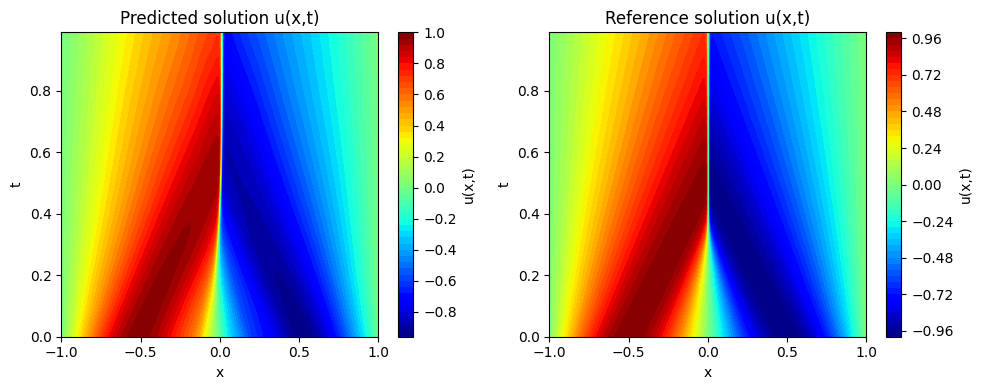

In [13]:
# Load reference solution
# Load reference solution
data = scipy.io.loadmat('burgers_shock.mat')
x_ref = data['x'].flatten()
t_ref = data['t'].flatten()
u_ref = data['usol']

# Evaluate the model on a grid for plotting
x_grid = torch.tensor(x_ref, dtype=torch.float32).reshape(-1, 1).to(device)
t_grid = torch.tensor(t_ref, dtype=torch.float32).reshape(-1, 1).to(device)
x_mesh, t_mesh = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze())
x_flat, t_flat = x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1)
u_pred = model(torch.cat([x_flat, t_flat], dim=1)).detach().cpu().numpy().reshape(len(x_ref), len(t_ref))

# Compute relative L2 error
u_ref_flat = u_ref.T.flatten()
u_pred_flat = u_pred.flatten()
relative_error = np.linalg.norm(u_pred_flat - u_ref_flat) / np.linalg.norm(u_ref_flat)
print(f'Relative L2 error: {relative_error}')

# Plot the predicted solution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.contourf(x_ref, t_ref, u_pred.T, levels=50, cmap='jet')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution u(x,t)')

# Plot the reference solution
plt.subplot(1, 2, 2)
plt.contourf(x_ref, t_ref, u_ref.T, levels=50, cmap='jet')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Reference solution u(x,t)')

plt.tight_layout()
plt.show()


In [14]:
import jax.numpy as np
import jax.numpy as onp
from jax import random, jit, vmap, grad, device_put
from jax.example_libraries import optimizers

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Define the Burgers' equation parameters
nu = 0.01 / np.pi
T = 1.0
X = np.linspace(-1, 1, 100)[:, None]
T_vals = np.linspace(0, T, 100)[:, None]

# Initial condition: u(0,x) = -sin(pi*x)
def u_initial(x):
    return -np.sin(np.pi * x)

# Boundary conditions: u(t,-1) = 0, u(t,1) = 0
def u_boundary(t):
    return np.zeros_like(t)

# MLP definition
def MLP(layers, activation=np.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs

    return init, apply

@optimizers.optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m
        v = (1 - b2) * np.square(g) + b2 * v
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

class MLPregression:
    def __init__(self, layers, rng_key):
        self.net_init, self.net_apply = MLP(layers)
        params = self.net_init(rng_key)

        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, self.opt_update, self.get_params = adam(lr)
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        loss = np.mean((targets - outputs)**2)
        return loss 

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter=10):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

# Data Generator for collocation and boundary points
class DataGenerator:
    def __init__(self, X, Y, batch_size=128, rng_key=random.PRNGKey(123)):
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[idx, :]
        targets = Y[idx, :]
        return inputs, targets

    def __getitem__(self, index):
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

# Create collocation points
def create_collocation_points(num_points, rng_key):
    # Generate random uniform values for collocation points using JAX
    key1, key2 = random.split(rng_key)
    x_collocation = random.uniform(key1, (num_points, 1), minval=-1, maxval=1)
    t_collocation = random.uniform(key2, (num_points, 1), minval=0, maxval=T)
    return np.hstack((t_collocation, x_collocation))

# Generate training data
num_collocation = 10000
rng_collocation = random.PRNGKey(0)
X_collocation = create_collocation_points(num_collocation, rng_collocation)
Y_collocation = np.zeros((num_collocation, 1))  # Placeholder for the PINN output

# Initial condition points
T_vals = np.linspace(0, 1, 100)  # For 100 time points

# Define the boundary condition points
X_bc_left = np.hstack((T_vals[:, None], np.full((T_vals.shape[0], 1), -1)))  # Boundary condition at x = -1
Y_bc_left = np.zeros((T_vals.shape[0], 1))  # u(t, -1) = 0

X_bc_right = np.hstack((T_vals[:, None], np.full((T_vals.shape[0], 1), 1)))  # Boundary condition at x = 1
Y_bc_right = np.zeros((T_vals.shape[0], 1))  # u(t, 1) = 0

# Now ensure Y_ic, Y_bc_left, and Y_bc_right are all correctly shaped
Y_ic = u_initial(X_ic[:, 1:])  # Ensure it's shaped as (100, 1)
Y_ic = Y_ic.reshape(-1, 1)  # Ensure correct shape

# Combine all points for the dataset
X_all = np.vstack([X_collocation, X_ic, X_bc_left, X_bc_right])
Y_all = np.vstack([Y_collocation, Y_ic, Y_bc_left, Y_bc_right])  # All Y values should be (N, 1)

# Create the dataset
dataset = DataGenerator(X_all, Y_all, batch_size=32)

# Set up the model
layers = [2, 128, 128, 1]  # Input layer: 2 (t, x), output layer: 1 (u)
model = MLPregression(layers, rng_key=random.PRNGKey(0))

# Train the model
model.train(dataset, nIter=10000)



100%|██████████| 10000/10000 [00:55<00:00, 178.81it/s, Loss=0.00017134802]


Relative L2 Error: 9.911329e-01


ValueError: x and y must have same first dimension, but have shapes (256,) and (25600,)

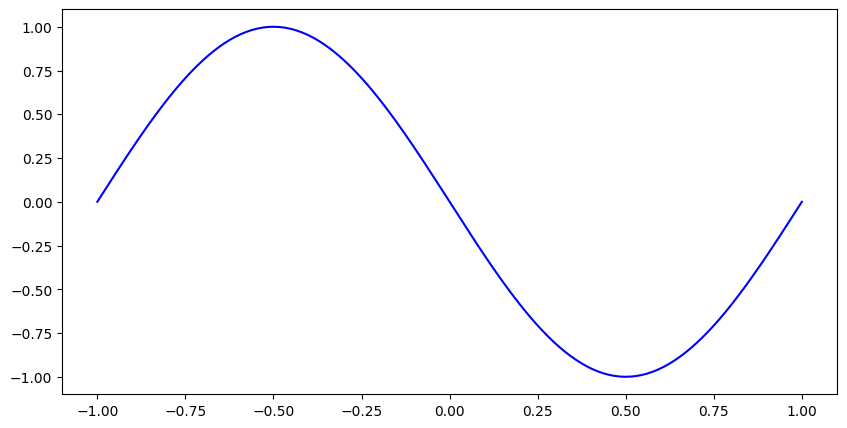

In [21]:
# Generate test data from reference solution
data = scipy.io.loadmat('burgers_shock.mat')
X = data['x'].flatten()  # Ensure X_ref is 1D
T = data['t'].flatten()  # Ensure T_ref is 1D
U = data['usol']

# Normalize the input
mu_X, sigma_X = X.mean(0), X.std(0)
X_star = (X - mu_X) / sigma_X

# Create a meshgrid from T_ref and X_ref
T_grid, X_grid = np.meshgrid(T, X)

# Flatten the grids to create X_star
X_star = np.hstack((T_grid.flatten()[:, None], X_grid.flatten()[:, None]))

# Evaluate model on the reference data
T_pred = model.predict(model.get_params(model.opt_state), X_star)

# Calculate the relative L2 error
error = np.linalg.norm(T_pred.flatten() - U.flatten()) / np.linalg.norm(U.flatten())
print('Relative L2 Error: %e' % error)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(X, U[:, 0], 'b-', label='Reference Solution at t=0')
plt.plot(X, T_pred.flatten(), 'r--', label='PINN Solution at t=0')  # Flatten T_pred
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('Burgers\' Equation Solution Comparison at t=0')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(np.array(model.loss_log))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.grid()
plt.show()